Notebook for taking raw parquet file reads and subsetting to regions of interest \
and collapsing samples by cell type. This notebook outputs parquet files by celltype.

# LOYFER

In [1]:
import pandas as pd
import glob
import numpy as np
import itertools
import functools
import os
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col, expr
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



In [2]:
#--- Local paths
ROOT_DIR = '/analysis/gh-msun/projects'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + f'/{PROJECT_SLUG}'
DATA_DIR = ROOT_DIR + f'/{PROJECT_SLUG}' + '/stage'
SAMPLE_PATH = DATA_DIR + '/metadata/samples_wgbs.20230329.tsv'

#--- parquet
PARQUET_PATH_LIST_HG38 = [
   #  '/analysis/data/hg38_20160816.pat.db_version.parquet'
    '/analysis/data/GSE186458_hg19.pat.parquet'
]

#--- regions
REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'

REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#-- output
RESULTS_PATH='/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/mixture_source/'

# Subset parquets to regions of interest

### Load regions we want to subset
Load regions of interest to subset. e.g. The ATLAS dataframe contains BLUEPRINT immune regions only. The regions we want to subset to should be represented as a set of region id called `subset_region_set`

In [9]:
# #-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# # BLUEPRINT immune regions
# ATLAS_PATH = PROJECT_DIR + f'/output/deconv_inhouse_v2.atlas.tsv.gz'
# atlas = pd.read_csv(ATLAS_PATH, sep='\t')
# subset_region_set = set(atlas.region_id)
# #-----------------------------------------------------------------------------

# # filter regions down to regions of interest
# region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)
# region_df_subset = region_df[region_df['region_id'].isin(subset_region_set)]
# region_df_subset.shape


In [10]:
# cpg_map.head()

In [11]:
# %%time
# cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')
# ridxs = ~cpg_map['cpg_index_hg38'].isna()
# hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
# hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)
region_df.shape

(1658, 6)

In [13]:
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id
0,chr1,1114771,1114971,20117,20130,Immune_Broad_B-chr1:1114772-1114971
1,chr1,1157450,1157720,21684,21704,Immune_Broad_NK-chr1:1157451-1157720
2,chr1,1157879,1158277,21710,21727,Immune_Broad_NK-chr1:1157880-1158277
3,chr1,1652503,1652793,41590,41599,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...
4,chr1,1849567,1849674,46692,46698,Pancreas_Acinar-chr1:1849568-1849674


In [14]:
# %%time
# region_df['region_cpg_index_max'] -= 1
# region_df.sort_values('region_cpg_index_min', inplace=True)
# region_df['region_cpg_index_min'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
# region_df['region_cpg_index_max'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

# region_df.shape[0], region_df['region_id'].nunique()

### Load parquet file as a pyspark dataframe

In [15]:
# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [16]:
PAT_COLS = [
    'sample_id', 'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string'
]

In [17]:
pat_parquet_files = [spark.read.parquet(ifile).select(*PAT_COLS) for ifile in PARQUET_PATH_LIST_HG38]
pat_hg38_ddf = functools.reduce(DataFrame.unionByName, pat_parquet_files)
pat_hg38_ddf.printSchema()

root
 |-- sample_id: string (nullable = true)
 |-- molecule_id: long (nullable = true)
 |-- chr: string (nullable = true)
 |-- number_molecules: integer (nullable = true)
 |-- cpg_index_min: long (nullable = true)
 |-- cpg_index_max: long (nullable = true)
 |-- pat_string: string (nullable = true)



In [18]:
pat_hg38_ddf.show(5)

+----------+-----------+----+----------------+-------------+-------------+----------------+
| sample_id|molecule_id| chr|number_molecules|cpg_index_min|cpg_index_max|      pat_string|
+----------+-----------+----+----------------+-------------+-------------+----------------+
|GSM5652340|          0|chr1|               1|            1|            9|       CCCCCCCCC|
|GSM5652266|          0|chr1|               1|            1|            6|          CCCCCC|
|GSM5652340|          1|chr1|               4|            1|           13|   CCCCCCCCCCCCC|
|GSM5652266|          1|chr1|               1|            1|            8|        CCCCCCCC|
|GSM5652340|          2|chr1|               2|            1|           16|CCCCCCCCCCCCCCCC|
+----------+-----------+----+----------------+-------------+-------------+----------------+
only showing top 5 rows



In [19]:
# # check for duplicate molecules
# pat_hg38_ddf.count()
# pat_hg38_ddf.filter(col("number_molecules") == 1).count()
# pat_hg38_ddf.filter(col("number_molecules") > 1).count()

### Create a dataframe of reads that fall in the subsetted regions

In [20]:
%%time
BATCH_SIZE = 20
region_df['batch'] = (np.arange(region_df.shape[0])/BATCH_SIZE).astype(int)
rv_scores = list()
for batch, batch_region_df in region_df.groupby('batch'):
    rv_ov = list()
    print('---> Processing batch %i...' % batch)
    for _, row in batch_region_df.iterrows():
        ov_ddf = pat_hg38_ddf.filter(col('cpg_index_min')<=row['region_cpg_index_max'])\
            .filter(col('cpg_index_max') >= row['region_cpg_index_min'])\
            .withColumn('region_id', lit(row['region_id']))\
            .withColumn('region_cpg_index_min', lit(row['region_cpg_index_min']))\
            .withColumn('region_cpg_index_max', lit(row['region_cpg_index_max']))
        rv_ov.append(ov_ddf)
        
    scores_df = functools.reduce(DataFrame.union, rv_ov)
    scores_df_pandas = scores_df.toPandas()
    scores_df_spark = spark.createDataFrame(scores_df_pandas) 
    
    rv_scores.append(scores_df_spark)

---> Processing batch 0...
---> Processing batch 1...
---> Processing batch 2...
---> Processing batch 3...
---> Processing batch 4...
---> Processing batch 5...
---> Processing batch 6...
---> Processing batch 7...
---> Processing batch 8...
---> Processing batch 9...
---> Processing batch 10...
---> Processing batch 11...
---> Processing batch 12...
---> Processing batch 13...
---> Processing batch 14...
---> Processing batch 15...
---> Processing batch 16...
---> Processing batch 17...
---> Processing batch 18...
---> Processing batch 19...
---> Processing batch 20...
---> Processing batch 21...
---> Processing batch 22...
---> Processing batch 23...
---> Processing batch 24...
---> Processing batch 25...
---> Processing batch 26...
---> Processing batch 27...
---> Processing batch 28...
---> Processing batch 29...
---> Processing batch 30...
---> Processing batch 31...
---> Processing batch 32...
---> Processing batch 33...
---> Processing batch 34...
---> Processing batch 35...
--

In [21]:
%%time
combined_df = functools.reduce(DataFrame.union, rv_scores)

CPU times: user 5.83 ms, sys: 1e+03 ns, total: 5.83 ms
Wall time: 291 ms


In [22]:
rv_scores[0].show(5)

+----------+-----------+----+----------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+
| sample_id|molecule_id| chr|number_molecules|cpg_index_min|cpg_index_max|          pat_string|           region_id|region_cpg_index_min|region_cpg_index_max|
+----------+-----------+----+----------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+
|GSM5652266|      37267|chr1|               1|        20099|        20118|TCCCCCC.........CCCC|Immune_Broad_B-ch...|               20117|               20130|
|GSM5652266|      37271|chr1|               1|        20101|        20118|  CCCCCCCCCCT...CCCC|Immune_Broad_B-ch...|               20117|               20130|
|GSM5652340|      43105|chr1|               1|        20102|        20117|    CCCCCCCCCCCCCCCC|Immune_Broad_B-ch...|               20117|               20130|
|GSM5652266|      37275|chr1|               1|

In [23]:
rv_scores[2].filter(col("number_molecules") == 1).count()

106870

# Create parquet file for each cell type

In [24]:
dataSource = 'blueprint_loyfer2022'

cellType = [   
    'Blood-B', 
    'Blood-Granul', 
    'Blood-Mono+Macro', 
    'Blood-NK', 
    'Blood-T'
]

# get samples that fall under these cell types of interest
sample_df = pd.read_csv(SAMPLE_PATH, sep='\t')
ridxs = (sample_df['source']==dataSource)
ridxs &= sample_df['sample_group'].isin(cellType)
ref_sample_df = sample_df[ridxs].copy()
ref_sample_df.head()

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
101,GSM5652277,T,T (CD3+) cells,Blood-T,56.0,blueprint_loyfer2022,NaN,NaN
102,GSM5652278,T,T (CD3+) cells,Blood-T,55.0,blueprint_loyfer2022,NaN,NaN
103,GSM5652279,T,T helper(CD4+) cells,Blood-T,56.0,blueprint_loyfer2022,NaN,NaN
104,GSM5652280,T,T helper(CD4+) cells,Blood-T,50.0,blueprint_loyfer2022,NaN,NaN
105,GSM5652281,T,T helper(CD4+) cells,Blood-T,55.0,blueprint_loyfer2022,NaN,NaN


In [34]:
ref_sample_df.cell_type.unique()

array(['T (CD3+) cells', 'T helper(CD4+) cells',
       'T cytotoxic (CD8+) cells', 'T central memory CD4',
       'T effector cell CD8', 'T effector memory CD4',
       'T effector memory CD8', 'Naive T cells CD4', 'Naive T cells CD8',
       'NK', 'Monocytes', 'Macrophages', 'Granulocytes', 'B cells',
       'Memory B cells'], dtype=object)

In [25]:
# how many samples do each cell type have?
ref_sample_df.groupby('sample_group').sample_id.count()

sample_group
Blood-B              5
Blood-Granul         3
Blood-Mono+Macro    11
Blood-NK             3
Blood-T             22
Name: sample_id, dtype: int64

In [26]:
from pyspark.sql.functions import when

In [27]:
cellType

['Blood-B', 'Blood-Granul', 'Blood-Mono+Macro', 'Blood-NK', 'Blood-T']

In [28]:
%%time

# ---- loop for collapsing samples by cell type
region_read_count = []

for celltype in cellType:
    
    print(f'--> Processing: ### {celltype} ###')

    # get samples in the specified cell type
    samples_by_celltype = list(ref_sample_df[ref_sample_df['sample_group'] == celltype]['sample_id'])
    sample_size = len(samples_by_celltype)
    print(f'-------> sample size: {sample_size}')

    # filter reads that are from samples in samples_by_celltype
    print(f'-------> filtering reads')
    df_celltype = combined_df.filter((col('sample_id')).isin(samples_by_celltype))
    
    # explode rows by number_molecules (for random sampling in mixing)
    print(f'-------> exploding reads')
    df_celltype = df_celltype.withColumn('number_molecules', expr('explode(array_repeat(number_molecules,int(number_molecules)))'))
    
    # change 2 to 1
    df_celltype = df_celltype.withColumn('number_molecules', when(col('number_molecules') == 2, 1).otherwise(col('number_molecules')))
    df_celltype.show(5)
    
    # save parquet file
    print(f'-------> saving as parquet files')
    RESULT_PARQUET_PATH = RESULTS_PATH + 'collapsed_reads_' + celltype + '/'
    df_celltype.write.mode('overwrite').parquet(RESULT_PARQUET_PATH)
    
    # count reads per region
    print(f'-------> counting reads per region')
    read_count_by_region = df_celltype.groupBy('region_id').count().toPandas()
    
    # append read count 
    region_read_count.append(read_count_by_region)
    

--> Processing: ### Blood-B ###
-------> sample size: 5
-------> filtering reads
-------> exploding reads
+----------+-----------+----+----------------+-------------+-------------+------------------+--------------------+--------------------+--------------------+
| sample_id|molecule_id| chr|number_molecules|cpg_index_min|cpg_index_max|        pat_string|           region_id|region_cpg_index_min|region_cpg_index_max|
+----------+-----------+----+----------------+-------------+-------------+------------------+--------------------+--------------------+--------------------+
|GSM5652316|      27747|chr1|               1|        20105|        20122|TCCCCCCCTC..TTTTTT|Immune_Broad_B-ch...|               20117|               20130|
|GSM5652316|      27748|chr1|               1|        20107|        20118|      TCTCCCTCTCTT|Immune_Broad_B-ch...|               20117|               20130|
|GSM5652316|      27752|chr1|               1|        20110|        20118|         CCCCCTCTT|Immune_Broad_B-c

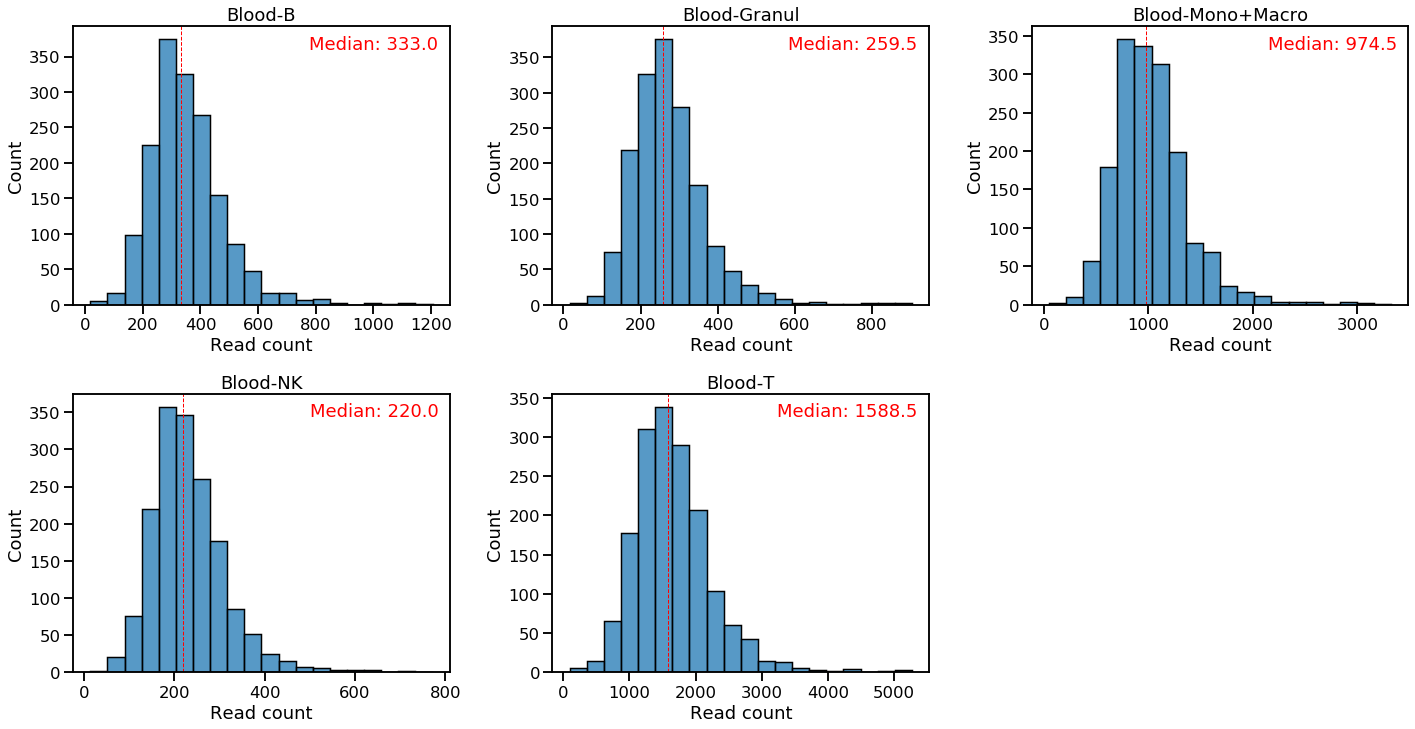

In [33]:
sns.set_context('talk')

# Blood-B                   5
# Blood-Granul              3
# Blood-Mono+Macro         11
# Blood-NK                  3
# Blood-T                  22

celltype_subset = ['Blood-B', 'Blood-Granul', 'Blood-Mono+Macro', 'Blood-NK', 'Blood-NK', 'Blood-T']

matched_elements = [x for x in cellType if x in celltype_subset]
matched_indexes = [i for i, x in enumerate(cellType) if x in celltype_subset]

region_read_count_subset = [region_read_count[i] for i in matched_indexes]


# Create a large figure
fig = plt.figure(figsize=(20, 20))

# Loop over the dataframes
for i, (df, title) in enumerate(zip(region_read_count_subset, matched_elements), start=1):
    # Create a subplot for each dataframe
    ax = fig.add_subplot(4, 3, i)  

    # Plot the histogram of the 'count' column using seaborn
    sns.histplot(df['count'], bins=20, edgecolor='black', ax=ax)

    # Calculate the median
    median = df['count'].median()

    # Add a vertical line for the median
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)

    # Add text in the upper right corner
    ax.text(0.97, 0.97, f'Median: {median}', ha='right', va='top', transform=ax.transAxes, color='red') 

    # Set the title from the titles list
    ax.set_title(title)
    
    # Set x-axis label
    ax.set_xlabel('Read count')

# Add spacing between plots
plt.tight_layout()
# Display the plot
plt.show()